In [46]:
import numpy as np
import matplotlib.pyplot as plt
import time
# import mkl

# mkl.set_num_threads(4)
np.random.seed(1234)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [16, 9]

### Handy utility functions

In [47]:
def append_ones(matrix, axis=1):
    return np.concatenate((matrix, np.ones((matrix.shape[0], 1), dtype=np.float32)), axis=axis)

def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def ones(*dims):
    return np.ones(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def randn(*dims):
    return np.random.randn(*dims).astype(np.float32)

def chunks(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def as_matrix(vector):
    return np.reshape(vector, (-1, 1))

def tiles(examples):
    rows_count = examples.shape[0]
    cols_count = examples.shape[1]
    tile_height = examples.shape[2]
    tile_width = examples.shape[3]
    
    space_between_tiles = 2
    img_matrix = np.empty(shape=(rows_count * (tile_height + space_between_tiles) - space_between_tiles,  
                                 cols_count * (tile_width + space_between_tiles) - space_between_tiles))
    img_matrix.fill(np.nan)

    for r in range(rows_count):
        for c in range(cols_count):
            x_0 = r * (tile_height + space_between_tiles)
            y_0 = c * (tile_width + space_between_tiles)
            ex_min = np.min(examples[r, c])
            ex_max = np.max(examples[r, c])
            img_matrix[x_0:x_0 + tile_height, y_0:y_0 + tile_width] = (examples[r, c] - ex_min) / (ex_max - ex_min)
    
    plt.matshow(img_matrix, cmap='gray', interpolation='none')
    plt.axis('off')
    plt.show()

def draw_rbm_filters(rbm):
    filters = np.reshape(np.transpose(rbm.W)[:-1, :-1], newshape=(8, -1, 28, 28))
    tiles(filters)

def draw_layer_filters(layer):
    filters = np.reshape(layer.W[:-1].T, newshape=(8, -1, 28, 28))
    tiles(filters)

### Activation functions

In [48]:
def sigmoid(batch, stochastic=False):
    activations = 1.0 / (1.0 + np.exp(-batch))
    if stochastic:
        return activations > rand(*activations.shape).astype(np.float32)
    else:
        return activations

def sigmoid_derivative(batch):
    s = sigmoid(batch)
    return s * (1.0 - s)

def gaussian(batch, stochastic=False):
    if stochastic:
        return np.random.normal(batch,scale=1, size= batch.shape) # 
    else:
        return np.copy(batch)

def gaussian_derivative(batch):
    return np.ones(batch.shape) # skoro nasz detrministyczny gauss jest funkca f(x) = x, to f'(x)= 1
    # return ???

# MNIST dataset

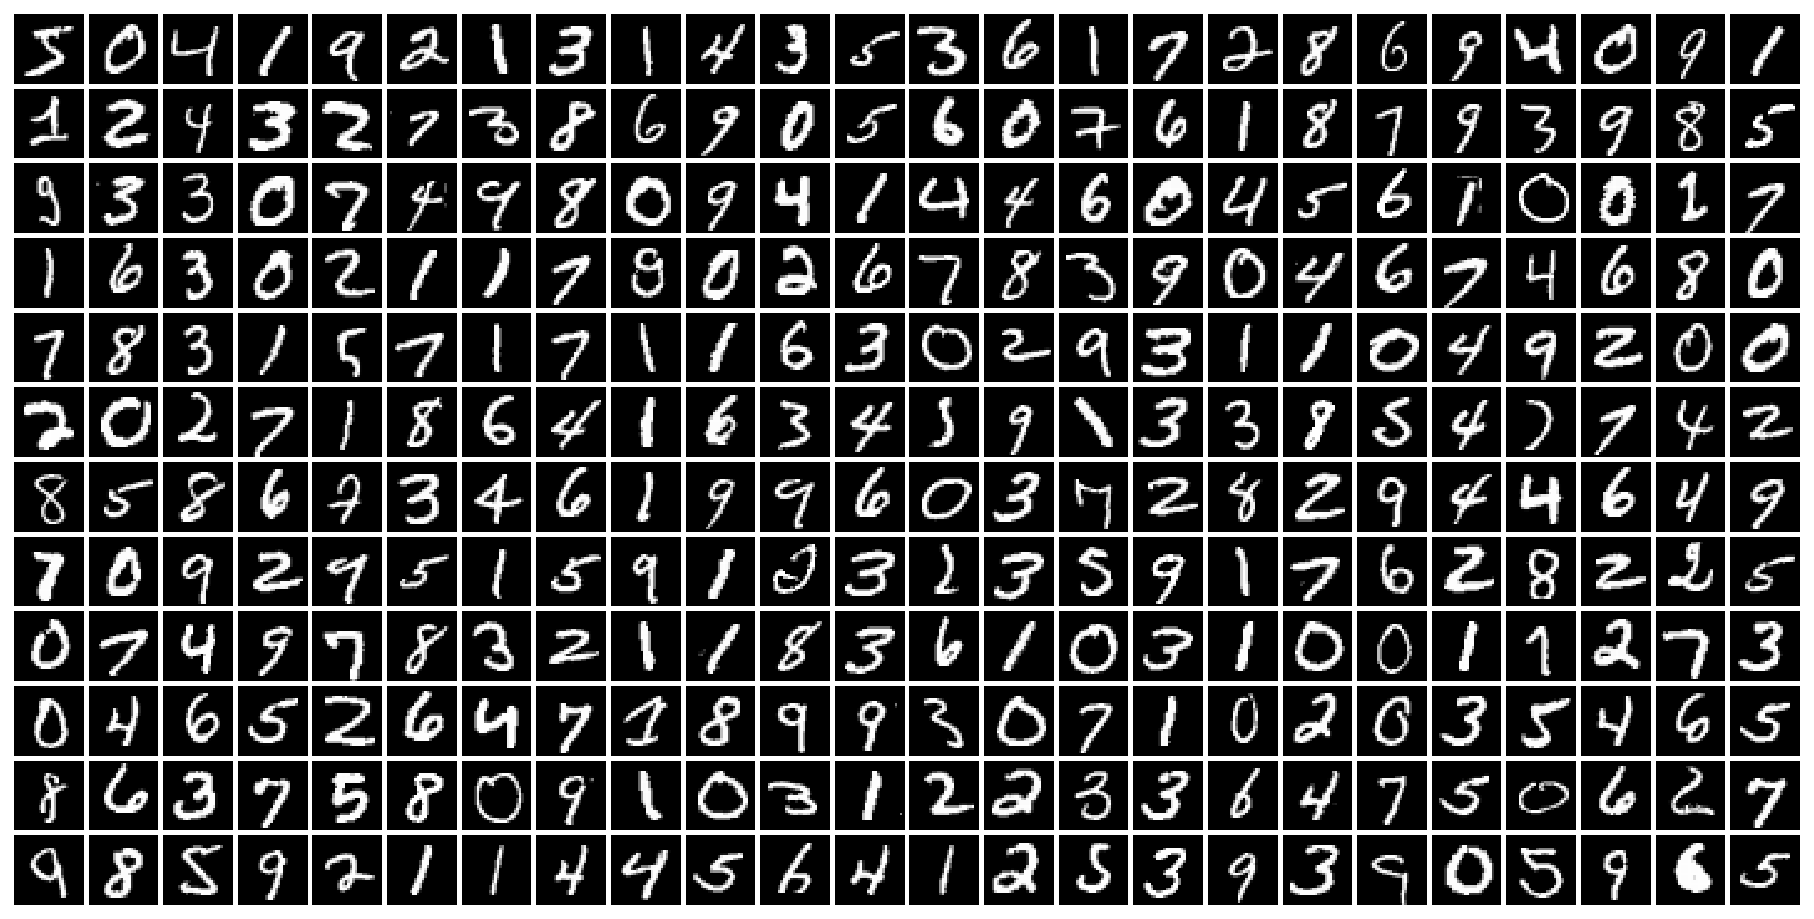

In [49]:
import mnist
digits = np.reshape(mnist.train_images()[:12*24], newshape=(12, 24, 28, 28))
tiles(digits)

# RBM & DBN training

In [50]:
class Rbm:
    def __init__(self, visible_size, hidden_size, visible_act_func, hidden_act_func, 
                 learning_rate, momentum, l2_penalty):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        
        self.visible_act_func = visible_act_func
        self.hidden_act_func = hidden_act_func
        
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.l2_penalty = l2_penalty
        
        self.reset()
    
    def reset(self):
        self.W = np.random.normal(scale=0.01, size=(self.visible_size+1, self.hidden_size+1)).astype(np.float32)
        self.W[:, -1] = 0.0
        self.W[-1, :] = 0.0
        self.M = zeros(self.visible_size+1, self.hidden_size+1)

In [51]:
def cdk(rbm, minibatch, k=1):
    observations_count = minibatch.shape[0]

    positive_visible = minibatch
    negative_visible = append_ones(zeros(observations_count, rbm.visible_size))

    positive_hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    negative_hidden = append_ones(zeros(observations_count, rbm.hidden_size))

    z = minibatch @ rbm.W[:, :-1]
    positive_hidden[:, :-1] = rbm.hidden_act_func(z)
    negative_hidden[:, :-1] = rbm.hidden_act_func(z, stochastic=True)

    for cd_i in range(k):
        negative_visible[:, :-1] = rbm.visible_act_func(negative_hidden @ rbm.W[:-1, :].T,
                                                        stochastic=True)
        z = negative_visible @ rbm.W[:, :-1]
        if cd_i < (k - 1):
            negative_hidden[:, :-1] = rbm.hidden_act_func(z, stochastic=True)
        else:
            negative_hidden[:, :-1] = rbm.hidden_act_func(z)

    rbm.M *= rbm.momentum
    rbm.M += (rbm.learning_rate / observations_count) * positive_visible.T @ positive_hidden
    rbm.M -= (rbm.learning_rate / observations_count) * negative_visible.T @ negative_hidden

    if rbm.l2_penalty is not None:
        rbm.M[:-1, :-1] = rbm.M[:-1, :-1] - rbm.learning_rate * rbm.l2_penalty * rbm.W[:-1, :-1]

    rbm.W += rbm.M;
    
def reconstuction_error(rbm, minibatch):
    observations_count = minibatch.shape[0]
    visible = zeros(observations_count, rbm.visible_size)
    hidden = append_ones(zeros(observations_count, rbm.hidden_size))
    
    hidden[:, :-1] = rbm.hidden_act_func(minibatch @ rbm.W[:, :-1])
    hidden[:, :-1] = (hidden[:, :-1] > rand(observations_count, rbm.hidden_size))
    
    visible = rbm.visible_act_func(hidden @ np.transpose(rbm.W[:-1, :]))
    
    error = minibatch[:, :-1] - visible
    error = np.sum(np.square(error)) / observations_count
    
    return error

In [52]:
def propagate_up(dbn, layers_count, visible):
    for i in range(layers_count):
        visible = append_ones(dbn[i].visible_act_func(visible @ dbn[i].W[:, :-1]))
    return visible

def propagate_down(dbn, layers_count, hidden):
    for i in reversed(range(layers_count)):
        hidden = append_ones(dbn[i].hidden_act_func(hidden @ np.transpose(dbn[i].W[:-1, :])))
    return hidden

def dbn_reconstuction_error(dbn, layer_idx, minibatch):
    propagated = propagate_up(dbn, layer_idx, minibatch)
    error = reconstuction_error(dbn[layer_idx], propagated)
    return error

def train_dbn_layer(dbn, layer_idx, dataset, batch_size):
    dataset = propagate_up(dbn, layer_idx, dataset)
    
    batches_limit = dataset.shape[0] / batch_size
    for batch_idx, batch in enumerate(chunks(dataset, batch_size)):
        cdk(dbn[layer_idx], batch)
        if batch_idx % round(batches_limit / 40) == 0: print("#", end="")

def train_dbn(dbn, dataset, monitoring_set, batch_size, epochs_count):
    for layer_idx in range(len(dbn)):
        print("\nLearning layer {}".format(layer_idx))
        
        for epoch in range(epochs_count):
            print("Epoch {}:".format(epoch+1),  end="\t")

            if epoch == 5:
                dbn[layer_idx].momentum = 0.9

            start_time = time.time()
            train_dbn_layer(dbn, layer_idx, dataset, batch_size)
            elapsed = time.time() - start_time

            error = dbn_reconstuction_error(dbn, layer_idx, monitoring_set)
            print("\telapsed: {0:>2.2f}s, reconstruction error: {1:>2.2f}".format(elapsed, error))

# Part 1. Autoencoder training with Nesterov accelerated gradient descend

In [53]:
class Layer:
    def __init__(self, visible_size, hidden_size, activation_fun, d_activation_fun, 
                 learning_rate, momentum, l2_penalty):
        self.visible_size = visible_size
        self.hidden_size = hidden_size
        
        self.activation_fun = activation_fun
        self.d_activation_fun = d_activation_fun
                
        self.learning_rate = learning_rate
        self.momentum = momentum
        
        self.l2_penalty = l2_penalty
        
        self.reset()
    
    def reset(self):
        self.W = np.random.normal(scale=0.01, size=(self.visible_size+1, self.hidden_size)).astype(np.float32)
        self.W[-1, :] = 0.0
        
        self.activations = None
        self.d_activations = None
        self.deltas = None

        self.M = zeros(self.visible_size+1, self.hidden_size)

## Error backpropagation with Nesterov accelerated gradient descend

__Forward pass.__ When ```compute_derivatives == false```, we are not training the network but use it to make predictions. In this case we cannot use weights in ```layer.W``` directly: in Nesterov method weights in this matrix are shifted along the direction of momentum (that is, they are at the point in the weight space where the gradient is calculated). We need to account for this when calculating the total input to the next layer.

In [54]:
def forward_pass(ae, batch, compute_derivatives):
    visible = batch
    
#     raise Exception("Forward pass is not implemented")
    
    for layer_idx, layer in enumerate(ae):
        z=None
        if not compute_derivatives:
            # We are using the network to make predictions. Fix evaluation of the total
            # input to the next layer (z) so that it uses the correct weights, and not
            # the weights where the gradient is calculated.
            
            z = visible @ (layer.W-layer.momentum *layer.M) # unsure czy Layer.M czy layer.momentum* layer.M bo to bylo 2 razy ianczje powiedziane chyba
        else:
            z = visible @ layer.W
            
        layer.activations = append_ones(layer.activation_fun(z))
        
        if compute_derivatives and (layer_idx < len(ae) - 1):
            layer.d_activations = layer.d_activation_fun(z)
            
        visible = layer.activations

    return visible[:, :-1]

__Backward pass.__ Implement Nesterov updates in the backward pass of error backpropagation.

Remember that the weights in ```layer.W``` are shifted along the direction of momentum. Before we change the momentum matrix (but after we have everything needed to calculate the gradient), we must fix (i.e. _un-shift_) these weights.

At the end of the backward pass, we must update the weight matrix accoring to the momentum interpretation of the Nesterov method.

In [55]:
def error_backpropagate(ae, batch):
    observations_count = batch.shape[0]
    
#     raise Exception("Error backpropagation is not implemented")

    for layer_idx, layer in reversed(list(enumerate(ae))):
        if layer_idx > 0:
            prev_layer = ae[layer_idx - 1]
            visible = prev_layer.activations
            
            prev_layer.deltas = (layer.deltas @ layer.W[:-1, :].T) * prev_layer.d_activations
        else:
            visible = batch
        
        # Fix weights in layer.W before changing the momentum matrix
        # layer.W = ???
        layer.W -= layer.momentum *layer.M
        
        layer.M *= layer.momentum
        layer.M -= (layer.learning_rate / observations_count) * (visible.T @ layer.deltas)
        
        if layer.l2_penalty > 0:
            layer.M[:-1, :] = layer.M[:-1, :] - layer.learning_rate * layer.l2_penalty * layer.W[:-1, :]
        
        layer.W += layer.M# normal momentum
        layer.W += layer.momentum*layer.M # nesterov addition

### Cross entropy cost

In [56]:
def xentropy(batch, reconstructions):
    observations_count = batch.shape[0]
    out = batch * np.log(reconstructions) + (1- batch) * np.log(1 - reconstructions)
    out = -(np.sum(out) / observations_count)    
    
#     norm = np.linalg.norm(batch-reconstructions,axis=1)
#     out = norm*norm/2
#     out = np.sum(out)
#     out = out/ observations_count
#     out = np.sum((reconstructions-batch))/observations_count
    return out

### Training procedure

In [57]:
def train_ae(ae, dataset, batch_size): # implemented
    batches_limit = dataset.shape[0] / batch_size
    batched_data = chunks(dataset, batch_size)
    
    for batch_idx, batch in enumerate(batched_data):
        reconstructions = forward_pass(ae, batch, True)
        
        #raise Exception("Gradient of the cross entropy cost wrt the deep AE output is not implemented")
        ae[-1].deltas = reconstructions-batch[:,:-1]
        
        error_backpropagate(ae, batch)
        
        if batch_idx % round(batches_limit / 40) == 0: print("#", end="")

In [58]:
def run_ae_training(ae, train_set, validation_set, batch_size, epochs_count):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch+1),  end="\t")
        
        if epoch == 10:
            for layer in ae:
                layer.momentum = 0.95
        elif epoch == 15:
            for layer in ae:
                layer.momentum = 0.97
        elif epoch == 20:
            for layer in ae:
                layer.momentum = 0.98
        elif epoch == 25:
            for layer in ae:
                layer.momentum = 0.99
        
        start_time = time.time()
        train_ae(ae, train_set, batch_size)
        elapsed = time.time() - start_time

        xe = xentropy(validation_set[:, :-1], forward_pass(ae, validation_set, False))
        print("\telapsed: {0:>2.2f}s, cross-entropy: {1:>2.2f}".format(elapsed, xe))

    print("Training finished!")

###  Initializing AE with DBN weights

In [59]:
def initialize_ae(ae, dbn):
    assert(len(ae) == 2*len(dbn))
    dbn_len = len(dbn)
    for i in range(dbn_len):
        ae[i].W[:,:]= np.copy(dbn[i].W[:,:-1])
    for i in range(dbn_len):
        ae[i+dbn_len].W[:,:]= np.copy(dbn[dbn_len-1-i].W.T[:,:-1])

## Autoencoder for MNIST digits

In [60]:
DATASET_SIZE = 10000 # 60000 for whole dataset
DIGIT_SIZE = 28

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_images = np.random.permutation(mnist_train_images)

mnist_train_images = np.reshape(mnist_train_images[:DATASET_SIZE],
                                newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))
mnist_train_images = append_ones(mnist_train_images)

monitoring_set_indeces = np.random.choice(mnist_train_images.shape[0], 512, replace=False)
monitoring_set = mnist_train_images[monitoring_set_indeces]

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = np.reshape(mnist_test_images, newshape=(-1, DIGIT_SIZE*DIGIT_SIZE))
mnist_test_images = append_ones(mnist_test_images)

In [61]:
VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE

BATCH_SIZE = 128
EPOCHS_COUNT = 50

RBM_LEARNING_RATE = 0.1
AE_LEARNING_RATE = 0.01
AE_MOMENTUM = 0.9
L2_PENALTY = 0.0002

In [62]:
from IPython.core.display import HTML

def compare_results(ae, dbn,
                    train_set, validation_set, monitoring_set,
                    batch_size, epochs_count):
    for layer in ae:
        layer.reset()
    
    display(HTML('<h3>DBN training</h3>'))
    train_dbn(dbn, train_set, monitoring_set, batch_size, epochs_count)
    
    initialize_ae(ae, dbn)
    dbn_reconstructions = np.reshape(forward_pass(ae, validation_set[:8*24, :], False),
                                     newshape=(8, 24, 28, 28))
    dbn_rec_cost = xentropy(validation_set[:, :-1],
                            forward_pass(ae, validation_set, False))
    
    display(HTML('<h3>Finetuning pretrained AE</h3>'))
    
    print("Reconstruction cost before finetuning: {0:>2.2f}\n".format(dbn_rec_cost))
    run_ae_training(ae, train_set, validation_set,
                    batch_size, epochs_count)
    
    display(HTML('<h3>Input minibatch</h3>'))
    tiles(np.reshape(validation_set[:8*24, :-1],
                     newshape=(8, 24, 28, 28)))
    
    display(HTML('<h3>Pretrained AE reconstructions</h3>'))
    tiles(dbn_reconstructions)
    
    display(HTML('<h3>Finetuned AE reconstructions</h3>'))
    ae_reconstructions = np.reshape(forward_pass(ae, validation_set[:8*24], False),
                                    newshape=(8, 24, 28, 28))
    tiles(ae_reconstructions)

###  Autoencoder network

Define the autoencoder network for MNIST digits. The network structure should be suitable for pretraining with the provided DBN.


Learning layer 0
Epoch 1:	########################################	elapsed: 0.81s, reconstruction error: 31.65
Epoch 2:	########################################	elapsed: 0.82s, reconstruction error: 24.73
Epoch 3:	########################################	elapsed: 0.64s, reconstruction error: 21.38
Epoch 4:	########################################	elapsed: 0.61s, reconstruction error: 19.00
Epoch 5:	########################################	elapsed: 1.10s, reconstruction error: 17.70
Epoch 6:	########################################	elapsed: 0.94s, reconstruction error: 15.49
Epoch 7:	########################################	elapsed: 1.04s, reconstruction error: 13.74
Epoch 8:	########################################	elapsed: 0.89s, reconstruction error: 12.60
Epoch 9:	########################################	elapsed: 0.77s, reconstruction error: 11.92
Epoch 10:	########################################	elapsed: 0.84s, reconstruction error: 11.48
Epoch 11:	###############################

Epoch 38:	########################################	elapsed: 0.43s, reconstruction error: 5.23
Epoch 39:	########################################	elapsed: 0.45s, reconstruction error: 5.38
Epoch 40:	########################################	elapsed: 0.44s, reconstruction error: 5.25
Epoch 41:	########################################	elapsed: 0.46s, reconstruction error: 5.27
Epoch 42:	########################################	elapsed: 0.44s, reconstruction error: 5.33
Epoch 43:	########################################	elapsed: 0.48s, reconstruction error: 5.23
Epoch 44:	########################################	elapsed: 0.47s, reconstruction error: 5.25
Epoch 45:	########################################	elapsed: 0.56s, reconstruction error: 5.27
Epoch 46:	########################################	elapsed: 0.48s, reconstruction error: 5.23
Epoch 47:	########################################	elapsed: 0.48s, reconstruction error: 5.20
Epoch 48:	########################################	elapsed: 

Epoch 25:	########################################	elapsed: 0.29s, reconstruction error: 9.48
Epoch 26:	########################################	elapsed: 0.27s, reconstruction error: 9.48
Epoch 27:	########################################	elapsed: 0.29s, reconstruction error: 9.49
Epoch 28:	########################################	elapsed: 0.30s, reconstruction error: 9.51
Epoch 29:	########################################	elapsed: 0.29s, reconstruction error: 9.54
Epoch 30:	########################################	elapsed: 0.29s, reconstruction error: 9.56
Epoch 31:	########################################	elapsed: 0.30s, reconstruction error: 9.58
Epoch 32:	########################################	elapsed: 0.29s, reconstruction error: 9.60
Epoch 33:	########################################	elapsed: 0.30s, reconstruction error: 9.62
Epoch 34:	########################################	elapsed: 0.28s, reconstruction error: 9.65
Epoch 35:	########################################	elapsed: 

c:\users\marcins\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Reconstruction cost before finetuning: 248.50

Epoch 1:	########################################	elapsed: 1.71s, cross-entropy: 123.25
Epoch 2:	########################################	elapsed: 1.58s, cross-entropy: 116.34
Epoch 3:	########################################	elapsed: 1.61s, cross-entropy: 112.87
Epoch 4:	########################################	elapsed: 1.71s, cross-entropy: 110.74
Epoch 5:	########################################	elapsed: 1.54s, cross-entropy: 109.08
Epoch 6:	########################################	elapsed: 1.51s, cross-entropy: 107.79
Epoch 7:	########################################	elapsed: 1.59s, cross-entropy: 106.81
Epoch 8:	########################################	elapsed: 1.54s, cross-entropy: 106.08
Epoch 9:	########################################	elapsed: 1.55s, cross-entropy: 105.42
Epoch 10:	########################################	elapsed: 1.65s, cross-entropy: 104.84
Epoch 11:	########################################	elapsed: 1.53s, cross

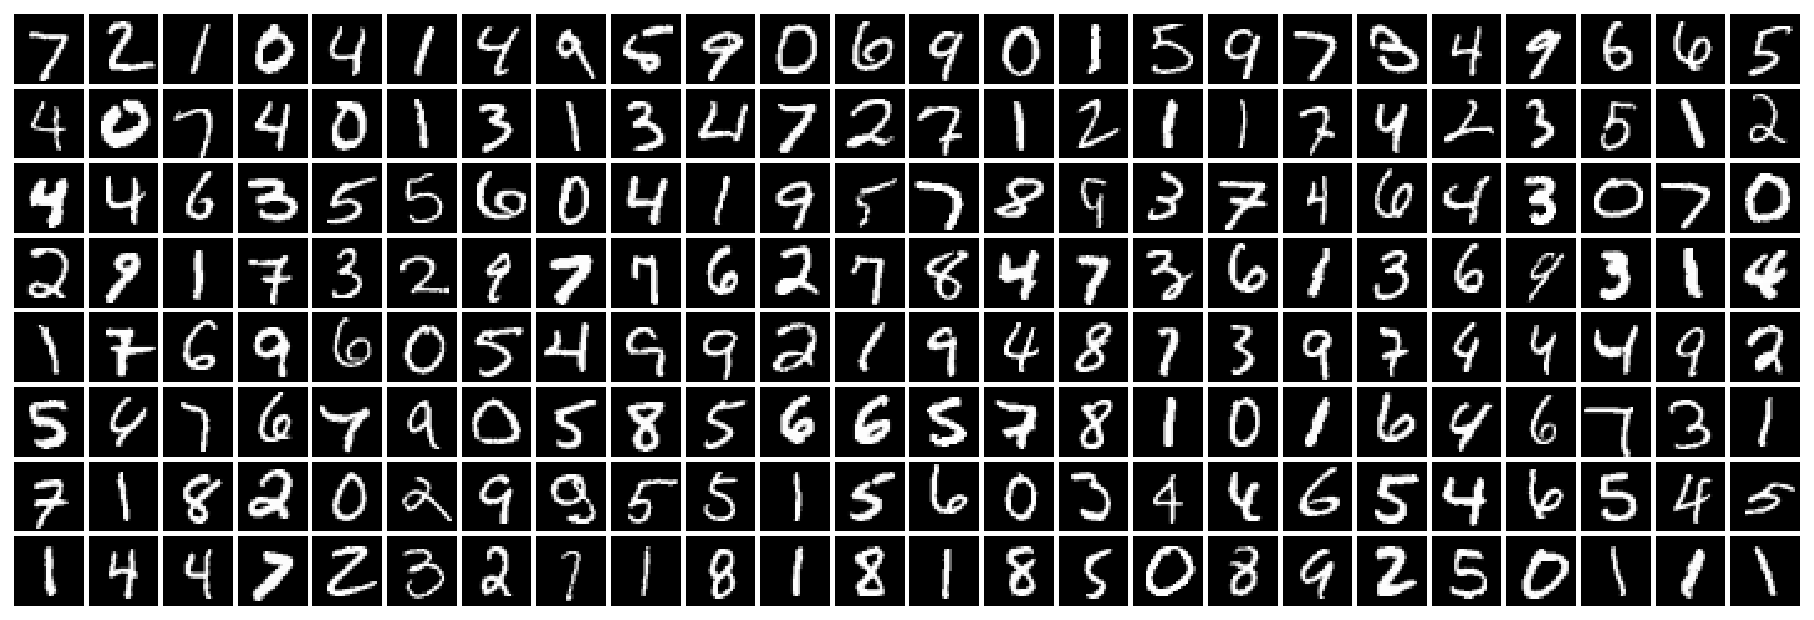

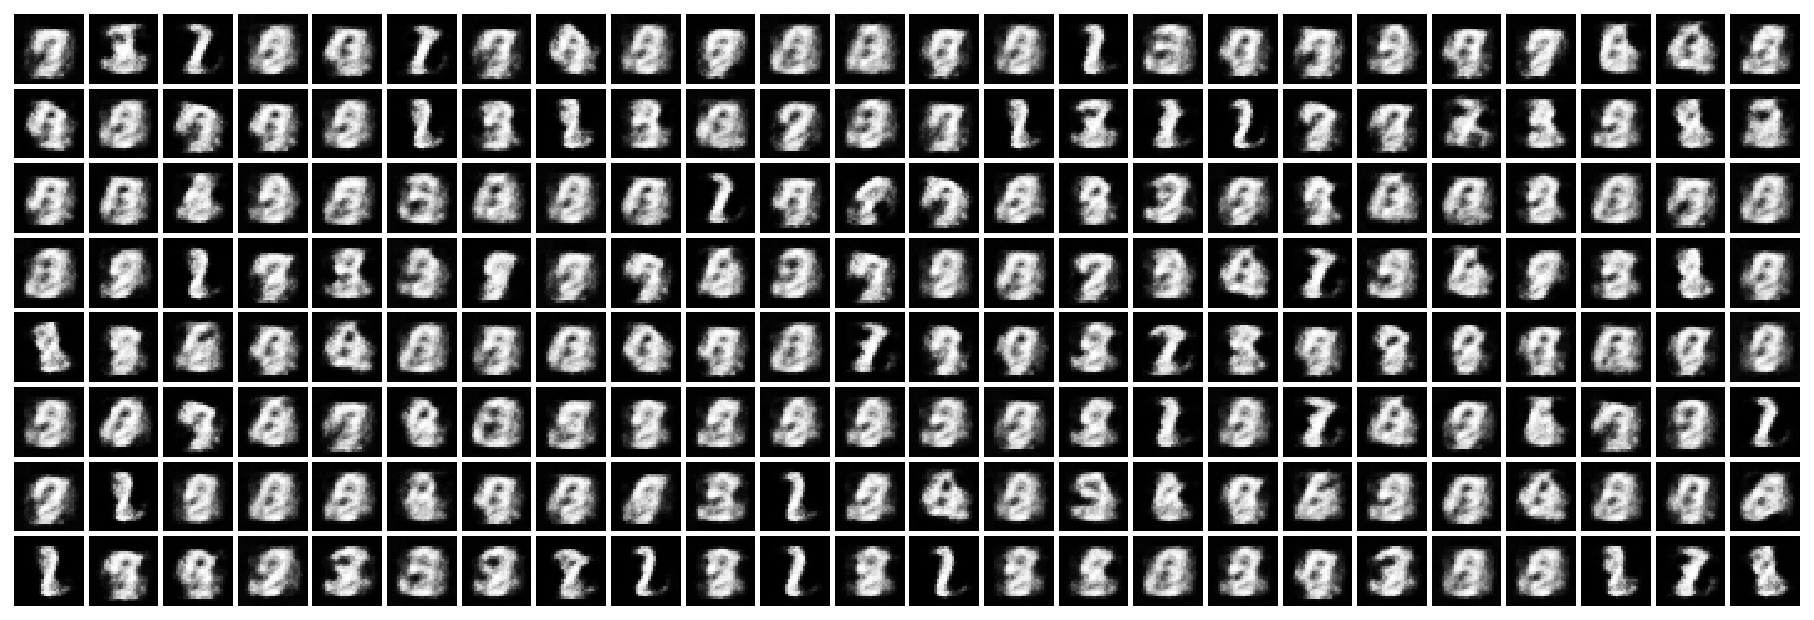

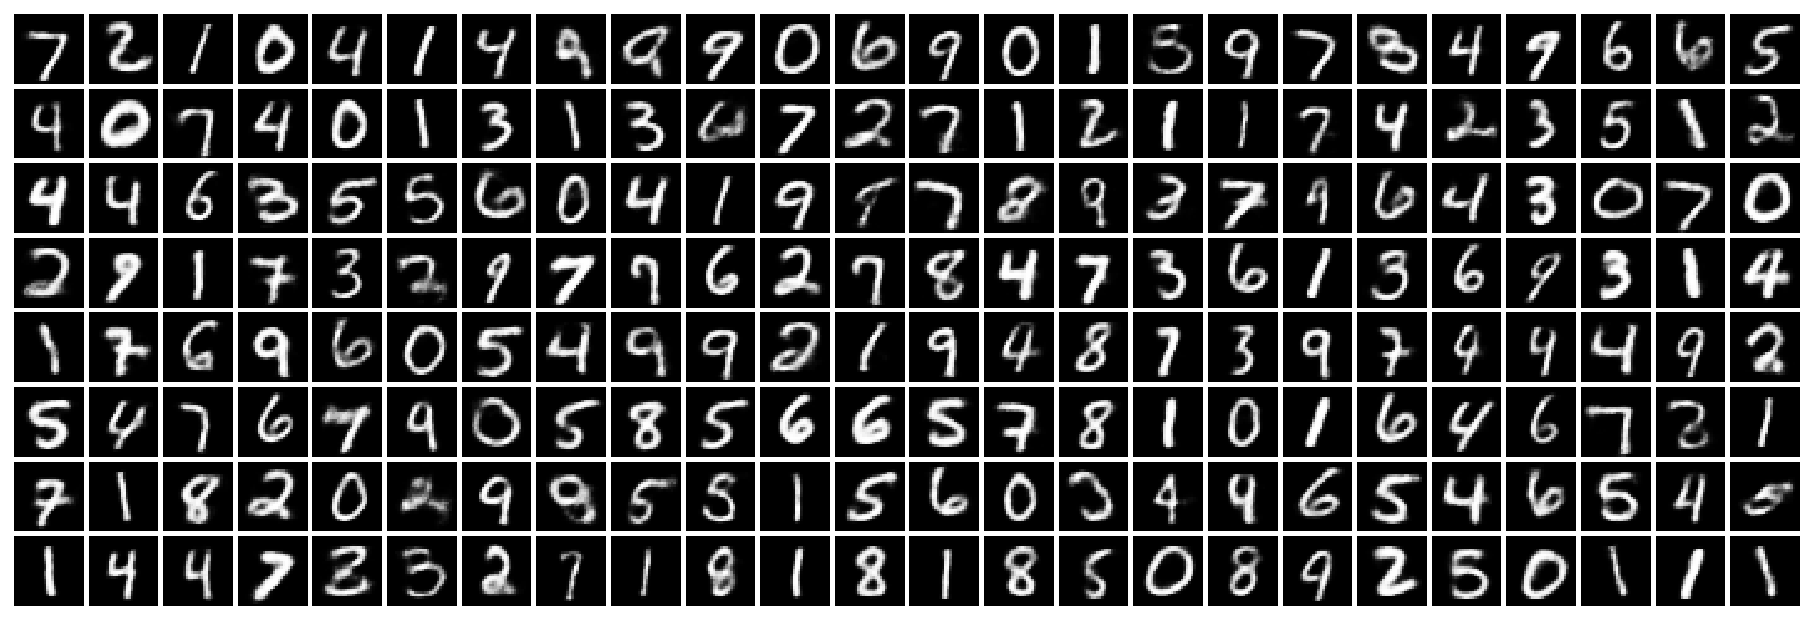

In [63]:
dbn = [
    Rbm(VISIBLE_LAYER_SIZE, 256, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY),
    Rbm(256, 128, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY),
    Rbm(128, 64, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY),
    Rbm(64, 10, sigmoid, gaussian, RBM_LEARNING_RATE / 10.0, 0.5, L2_PENALTY)
]

#raise Exception("AE structure is undefined!")
ae =  [
    Layer(VISIBLE_LAYER_SIZE, 256, sigmoid, sigmoid_derivative, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY),
    Layer(256, 128, sigmoid, sigmoid_derivative, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY),
    Layer(128, 64, sigmoid, sigmoid_derivative, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY),
    Layer(64, 10, gaussian, gaussian_derivative, AE_LEARNING_RATE / 10.0, AE_MOMENTUM, L2_PENALTY),
    Layer(10,64 , gaussian,gaussian_derivative , AE_LEARNING_RATE / 10.0, AE_MOMENTUM, L2_PENALTY),
    Layer(64, 128, sigmoid, sigmoid_derivative, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY),
    Layer(128, 256, sigmoid, sigmoid_derivative, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY),
    Layer(256,VISIBLE_LAYER_SIZE, sigmoid, sigmoid_derivative, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY)
]

compare_results(ae, dbn,
                mnist_train_images, mnist_test_images,
                monitoring_set,
                BATCH_SIZE, EPOCHS_COUNT)

# Part 2. Visualization of MNIST digits with an autoencoder

In [64]:
def run_2d_ae_training(ae, train_set, validation_set, batch_size, epochs_count):
    for epoch in range(epochs_count):
        print("Epoch {}:".format(epoch+1),  end="\t")
        
        if epoch == 10:
            for layer in ae:
                layer.momentum = 0.8
        elif epoch == 30:
            for layer in ae:
                layer.momentum = 0.9
        
        start_time = time.time()
        train_ae(ae, train_set, batch_size)
        elapsed = time.time() - start_time

        xe = xentropy(validation_set[:, :-1], forward_pass(ae, validation_set, False))
        print("\telapsed: {0:>2.2f}s, cross-entropy: {1:>2.2f}".format(elapsed, xe))

    print("Training finished!")

In [65]:
def plot_2d_mnist_scatter(X, y):
    fig, plot = plt.subplots()
    fig.set_size_inches(16, 16)
    plt.prism()

    for i in range(10):
        digit_indeces = y == i
        dim1 = X[digit_indeces, 0]
        dim2 = X[digit_indeces, 1]
        plot.scatter(dim1, dim2, label=str(i))

    plot.set_xticks(())
    plot.set_yticks(())

    plt.tight_layout()
    plt.legend()
    plt.show()

In [66]:
from IPython.core.display import HTML

def compare_2d_visualizations(ae, dbn,
                              train_set, validation_set, validation_labels, monitoring_set,
                              batch_size, epochs_count):
    for layer in ae:
        layer.reset()
    
    display(HTML('<h3>DBN training</h3>'))
    train_dbn(dbn, train_set, monitoring_set, batch_size, epochs_count)
    
    initialize_ae(ae, dbn)
    dbn_rec_cost = xentropy(validation_set[:, :-1],
                            forward_pass(ae, validation_set, False))
    
    _ = forward_pass(ae, validation_set, False)
    dbn_codes = ae[3].activations[:, :-1]
    
    display(HTML('<h3>Finetuning pretrained AE</h3>'))
    
    print("Reconstruction cost before finetuning: {0:>2.2f}\n".format(dbn_rec_cost))
    run_2d_ae_training(ae, train_set, validation_set,
                       batch_size, epochs_count)
    
    _ = forward_pass(ae, validation_set, False)
    ae_codes = ae[3].activations[:, :-1]
    
    display(HTML('<h3>2D codes from the pretrained AE</h3>'))
    plot_2d_mnist_scatter(dbn_codes, validation_labels)
    
    display(HTML('<h3>2D codes from the finetuned AE</h3>'))
    plot_2d_mnist_scatter(ae_codes, validation_labels)


In [67]:
DATASET_SIZE = 20000 # 60000 for whole dataset
DIGIT_SIZE = 28

##### Train set #####

mnist_train_images = mnist.train_images().astype(np.float32) / 255.0
mnist_train_images = np.random.permutation(mnist_train_images)

mnist_train_images = np.reshape(mnist_train_images[:DATASET_SIZE],
                                newshape=(DATASET_SIZE, DIGIT_SIZE*DIGIT_SIZE))
mnist_train_images = append_ones(mnist_train_images)

monitoring_set_indeces = np.random.choice(mnist_train_images.shape[0], 512, replace=False)
monitoring_set = mnist_train_images[monitoring_set_indeces]

##### Test set #####

mnist_test_images = mnist.test_images().astype(np.float32) / 255.0
mnist_test_images = np.reshape(mnist_test_images, newshape=(-1, DIGIT_SIZE*DIGIT_SIZE))
mnist_test_images = append_ones(mnist_test_images)
mnist_test_labels = mnist.test_labels()

In [68]:
VISIBLE_LAYER_SIZE = DIGIT_SIZE*DIGIT_SIZE

BATCH_SIZE = 128
EPOCHS_COUNT = 50

RBM_LEARNING_RATE = 0.1
AE_LEARNING_RATE = 0.01
AE_MOMENTUM = 0.5
L2_PENALTY = 0.0002

###  Autoencoder network for 2D visualization

Define the autoencoder network for MNIST digits. Use the network structure from the previous part, but change the size of the coding layer to 2 neurons.


Learning layer 0
Epoch 1:	########################################	elapsed: 1.11s, reconstruction error: 23.06
Epoch 2:	########################################	elapsed: 1.28s, reconstruction error: 17.88
Epoch 3:	########################################	elapsed: 1.21s, reconstruction error: 15.35
Epoch 4:	########################################	elapsed: 1.19s, reconstruction error: 13.94
Epoch 5:	########################################	elapsed: 1.19s, reconstruction error: 13.00
Epoch 6:	########################################	elapsed: 1.13s, reconstruction error: 12.06
Epoch 7:	########################################	elapsed: 1.23s, reconstruction error: 10.89
Epoch 8:	########################################	elapsed: 1.16s, reconstruction error: 10.29
Epoch 9:	########################################	elapsed: 1.13s, reconstruction error: 9.94
Epoch 10:	########################################	elapsed: 1.20s, reconstruction error: 9.87
Epoch 11:	#################################

Epoch 38:	########################################	elapsed: 0.95s, reconstruction error: 4.67
Epoch 39:	########################################	elapsed: 0.75s, reconstruction error: 4.68
Epoch 40:	########################################	elapsed: 0.76s, reconstruction error: 4.53
Epoch 41:	########################################	elapsed: 0.98s, reconstruction error: 4.62
Epoch 42:	########################################	elapsed: 0.83s, reconstruction error: 4.63
Epoch 43:	########################################	elapsed: 0.88s, reconstruction error: 4.57
Epoch 44:	########################################	elapsed: 0.86s, reconstruction error: 4.55
Epoch 45:	########################################	elapsed: 0.78s, reconstruction error: 4.59
Epoch 46:	########################################	elapsed: 0.80s, reconstruction error: 4.58
Epoch 47:	########################################	elapsed: 0.79s, reconstruction error: 4.62
Epoch 48:	########################################	elapsed: 

Epoch 25:	########################################	elapsed: 0.53s, reconstruction error: 9.88
Epoch 26:	########################################	elapsed: 0.52s, reconstruction error: 9.88
Epoch 27:	########################################	elapsed: 0.53s, reconstruction error: 9.86
Epoch 28:	########################################	elapsed: 0.51s, reconstruction error: 9.87
Epoch 29:	########################################	elapsed: 0.54s, reconstruction error: 9.87
Epoch 30:	########################################	elapsed: 0.52s, reconstruction error: 9.87
Epoch 31:	########################################	elapsed: 0.53s, reconstruction error: 9.86
Epoch 32:	########################################	elapsed: 0.53s, reconstruction error: 9.85
Epoch 33:	########################################	elapsed: 0.53s, reconstruction error: 9.83
Epoch 34:	########################################	elapsed: 0.54s, reconstruction error: 9.83
Epoch 35:	########################################	elapsed: 

Reconstruction cost before finetuning: 255.97

Epoch 1:	##

c:\users\marcins\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


######################################	elapsed: 3.04s, cross-entropy: 171.22
Epoch 2:	########################################	elapsed: 2.91s, cross-entropy: 166.98
Epoch 3:	########################################	elapsed: 2.96s, cross-entropy: 164.25
Epoch 4:	########################################	elapsed: 3.00s, cross-entropy: 162.27
Epoch 5:	########################################	elapsed: 3.16s, cross-entropy: 160.80
Epoch 6:	########################################	elapsed: 3.14s, cross-entropy: 159.55
Epoch 7:	########################################	elapsed: 3.27s, cross-entropy: 158.49
Epoch 8:	########################################	elapsed: 3.11s, cross-entropy: 157.49
Epoch 9:	########################################	elapsed: 3.13s, cross-entropy: 156.53
Epoch 10:	########################################	elapsed: 2.99s, cross-entropy: 155.61
Epoch 11:	########################################	elapsed: 3.09s, cross-entropy: 153.88
Epoch 12:	###############################

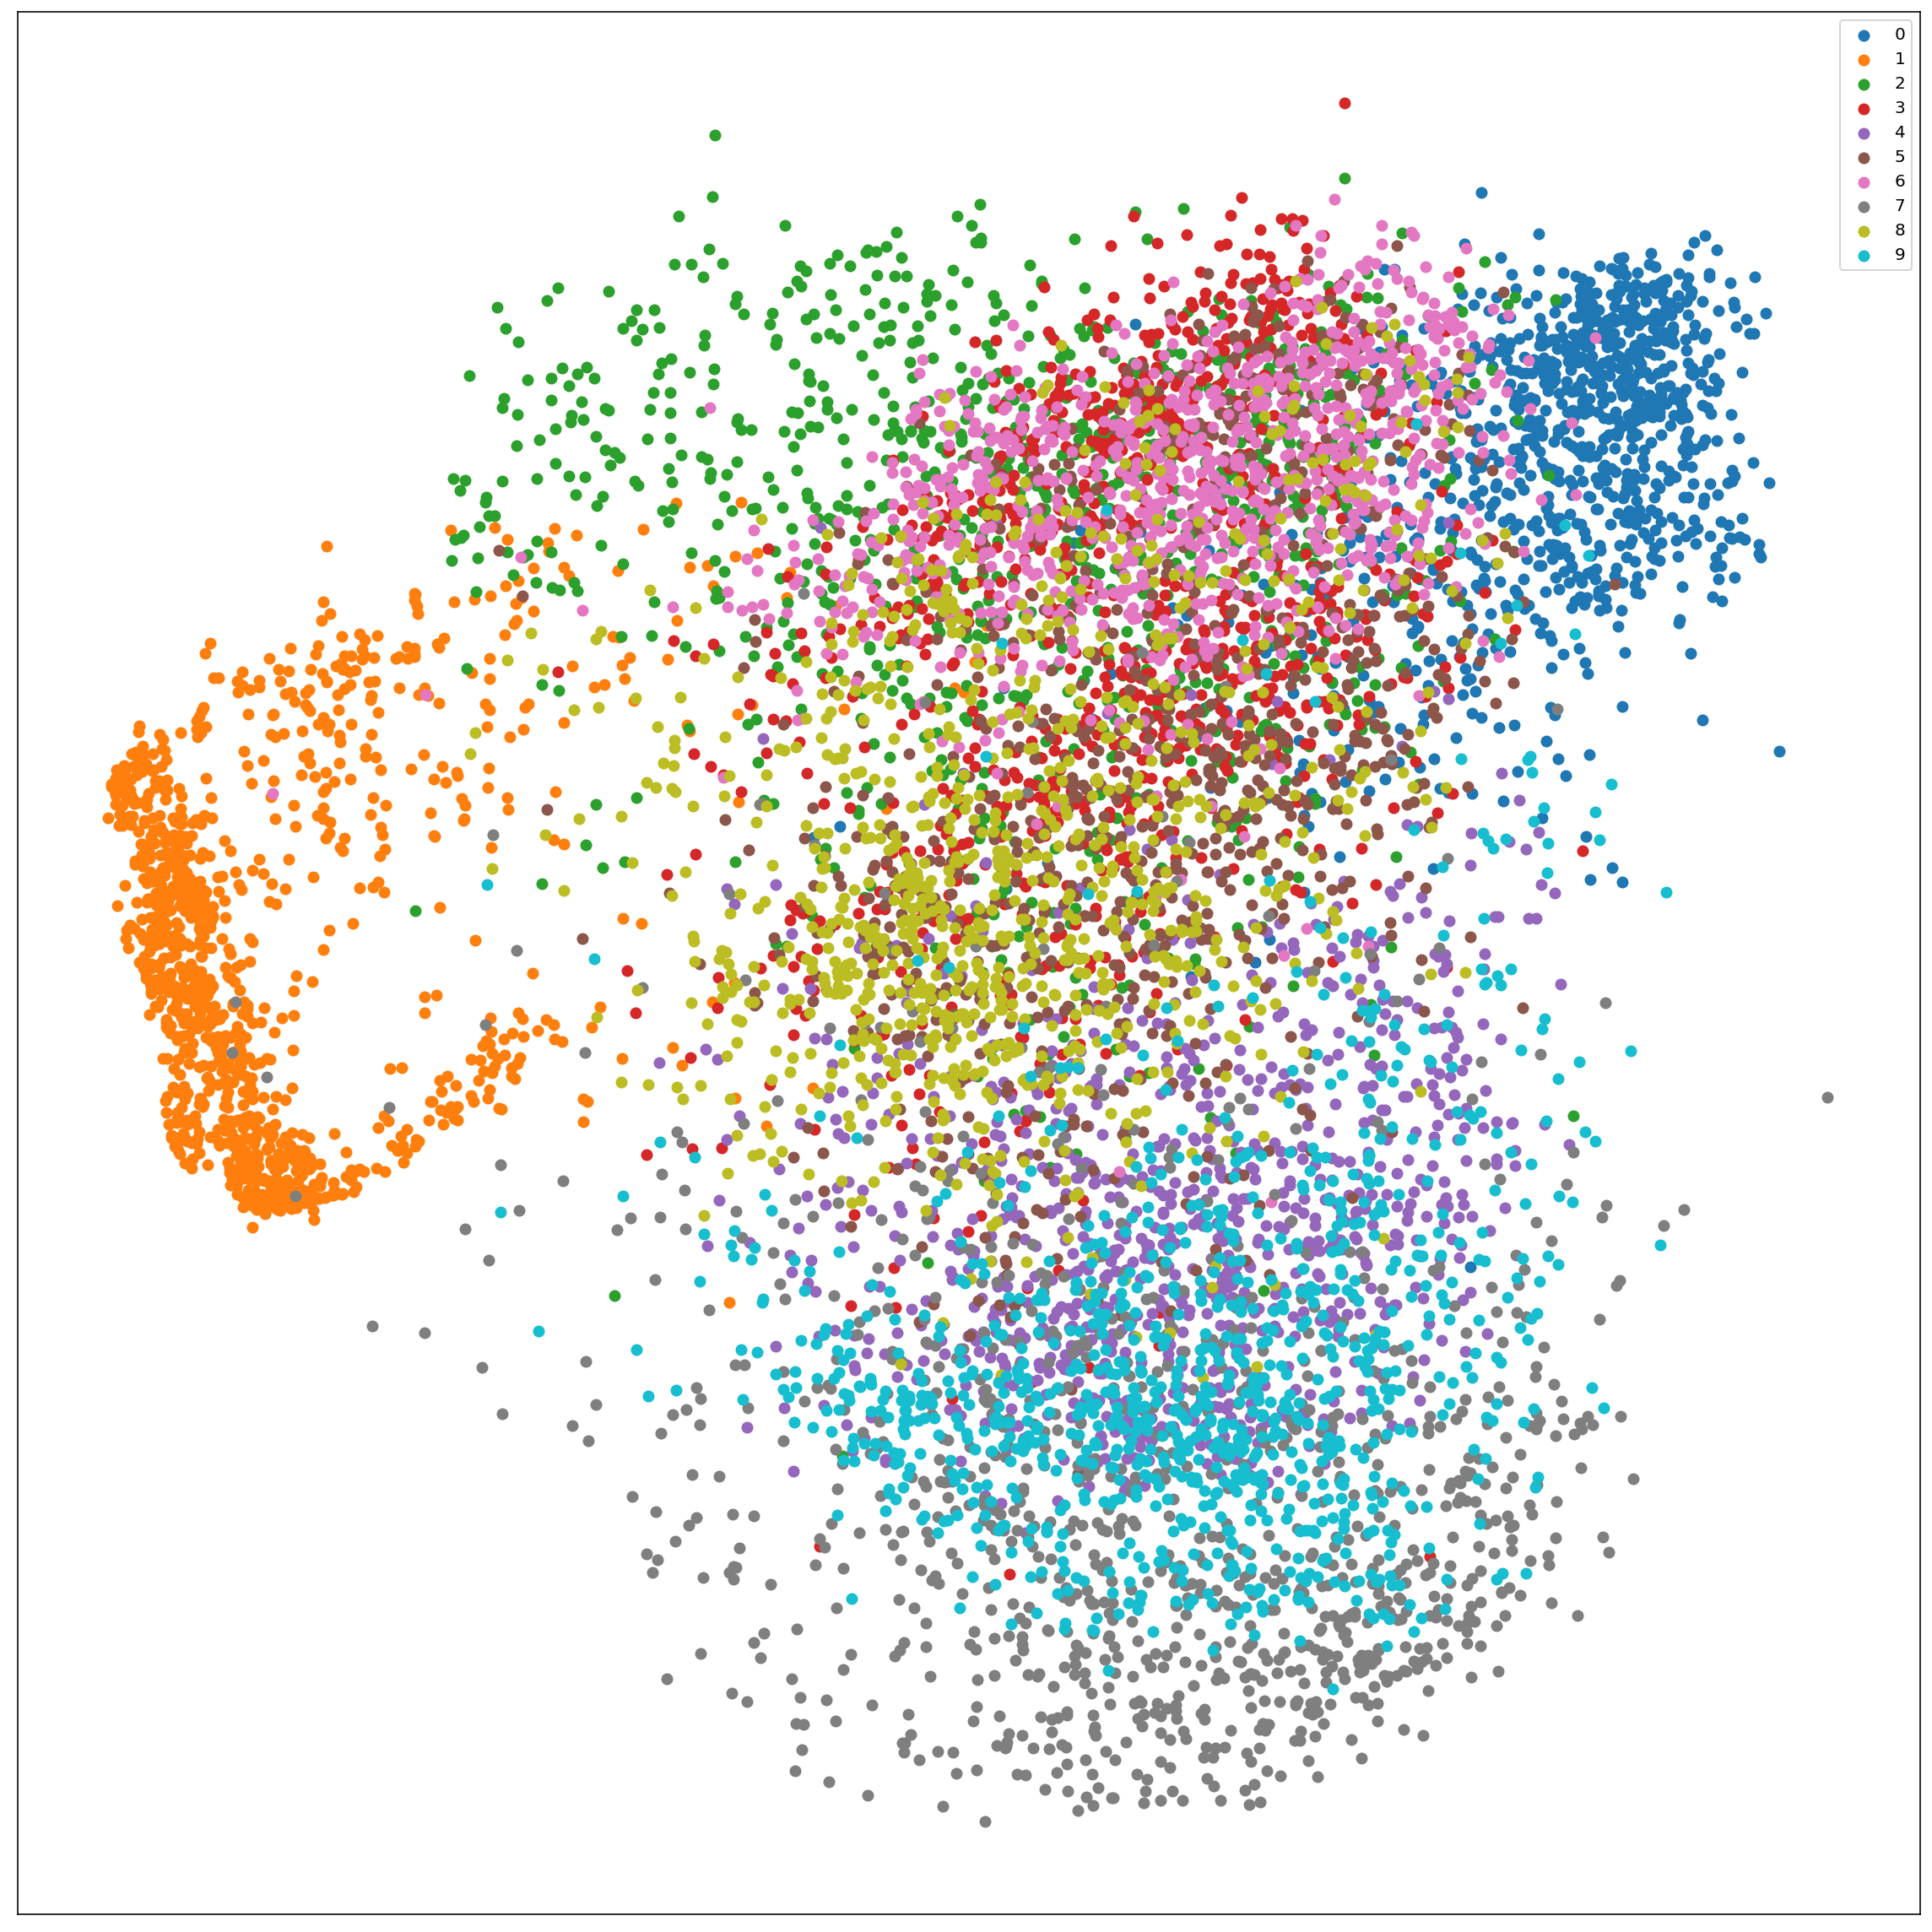

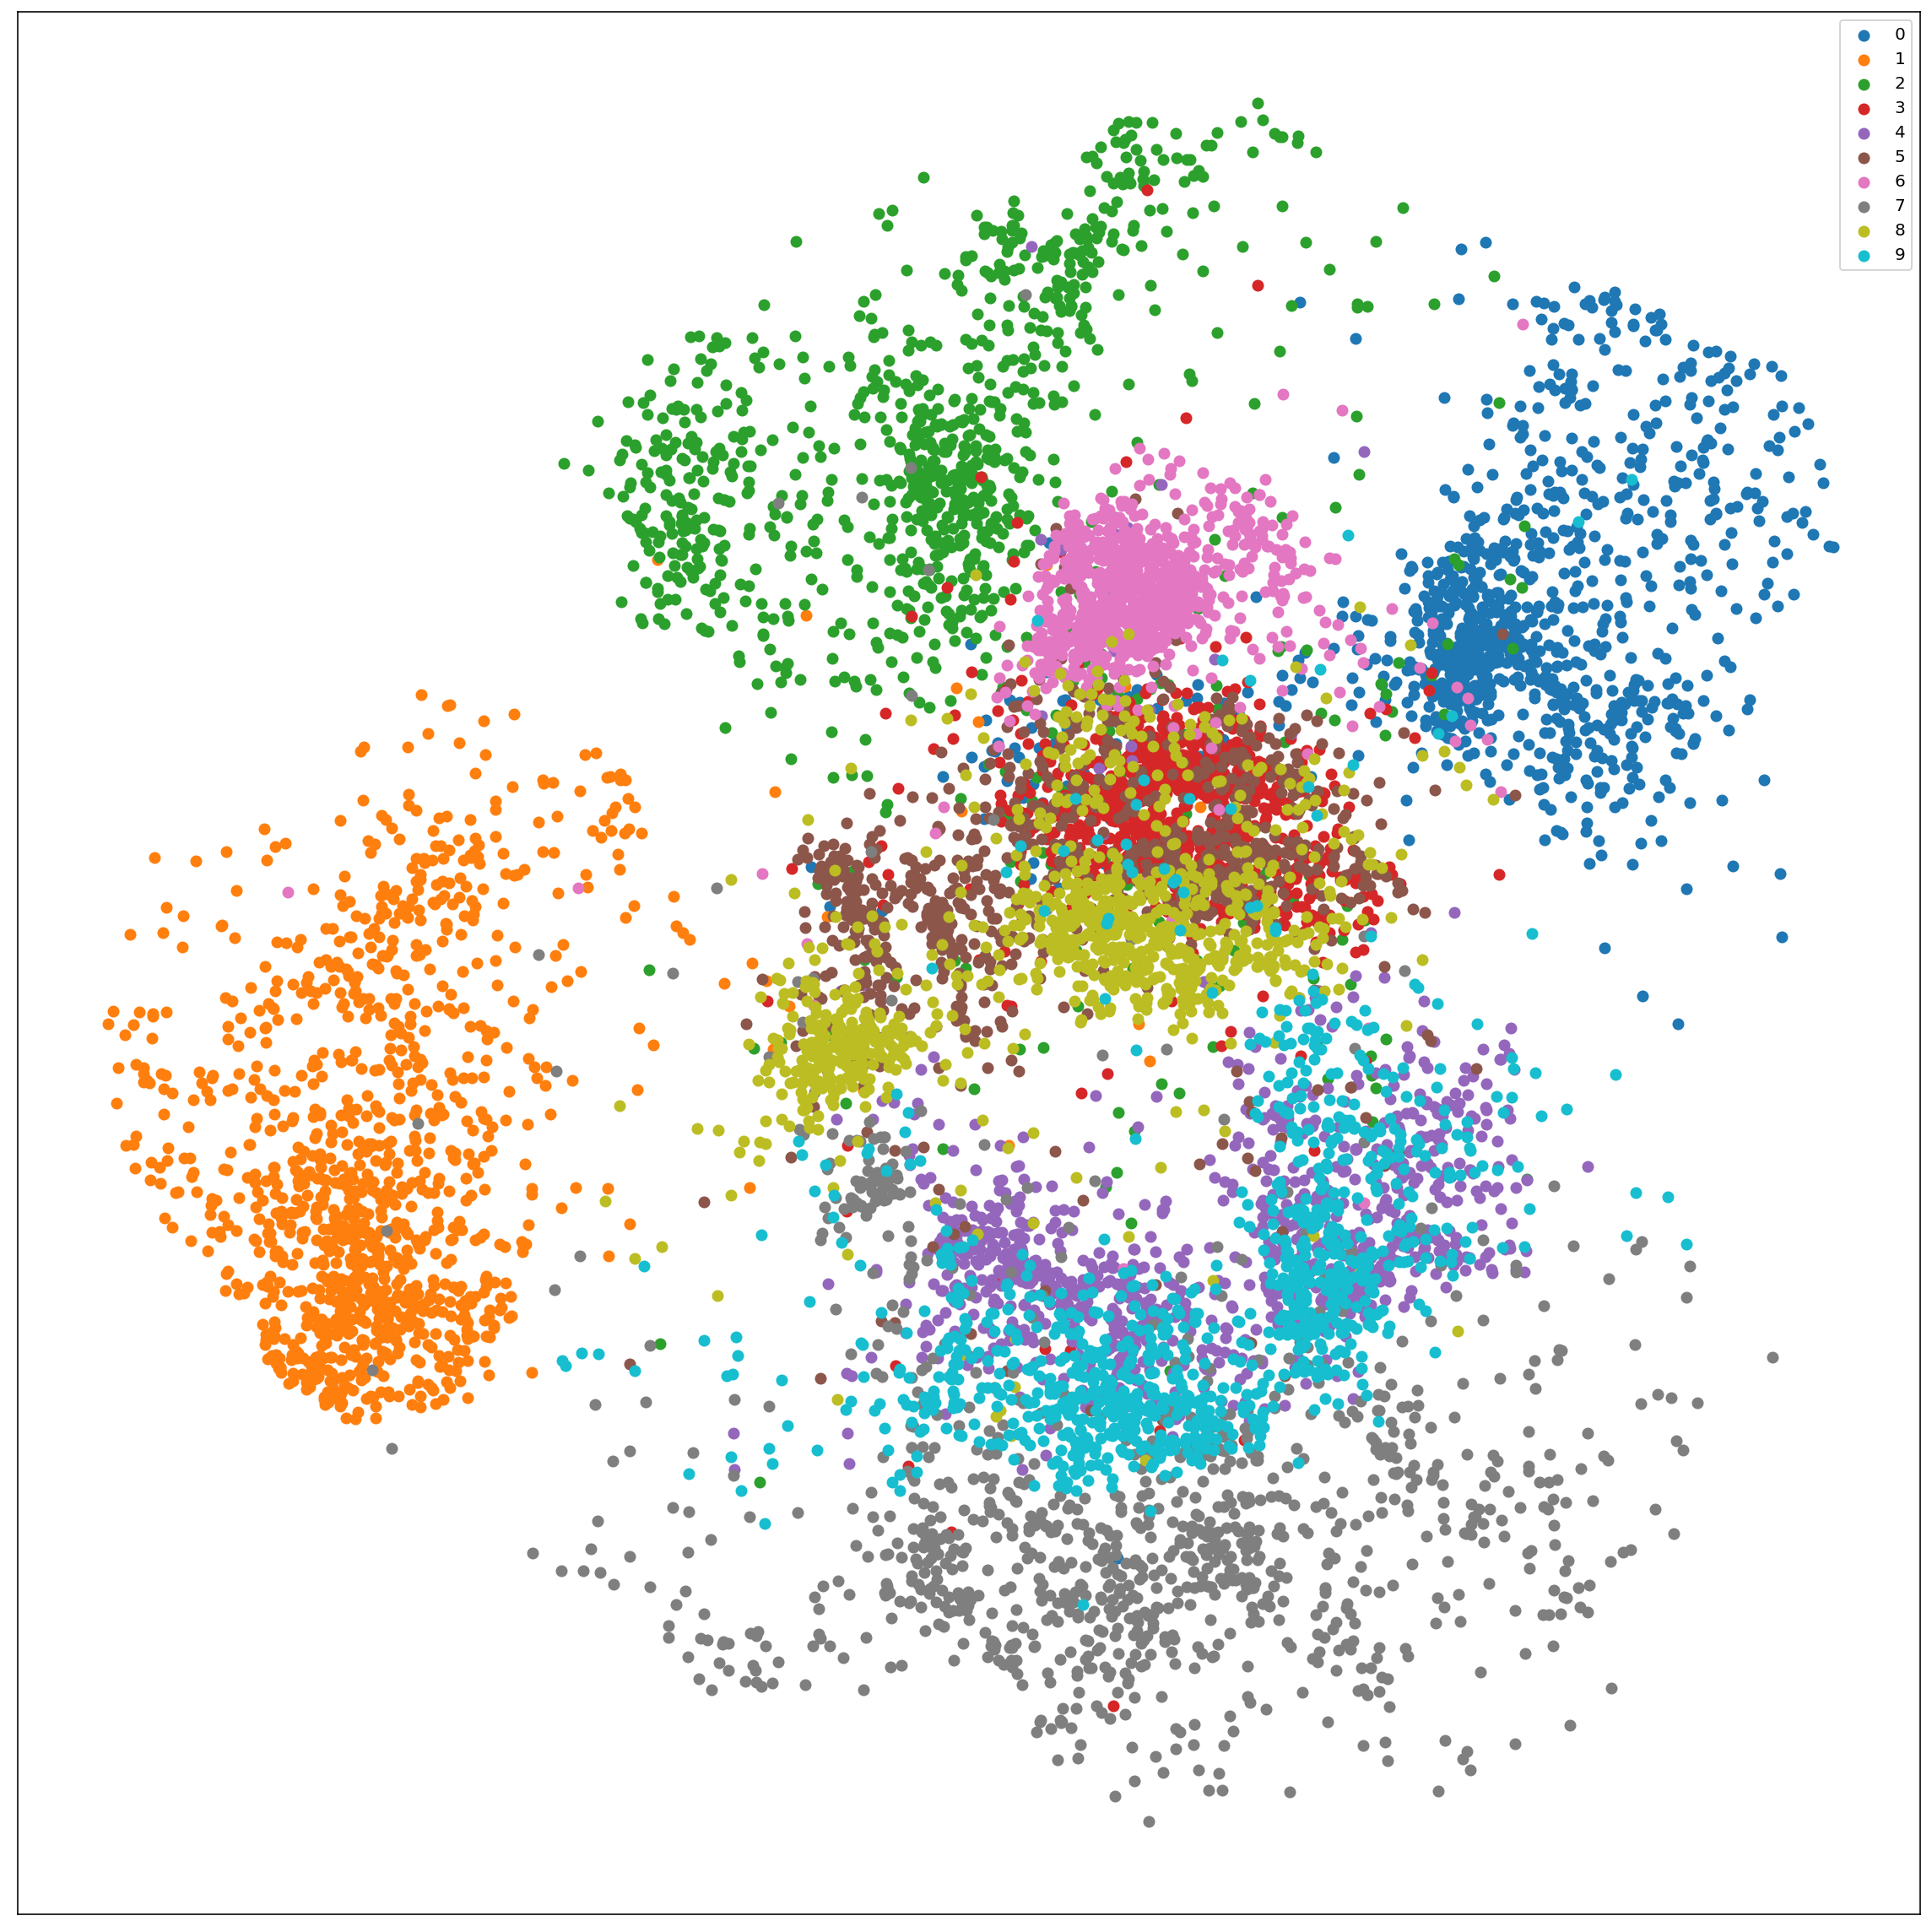

In [69]:
dbn = [
    Rbm(VISIBLE_LAYER_SIZE, 256, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY),
    Rbm(256, 128, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY),
    Rbm(128, 64, sigmoid, sigmoid, RBM_LEARNING_RATE, 0.5, L2_PENALTY),
    Rbm(64, 2, sigmoid, gaussian, RBM_LEARNING_RATE / 10.0, 0.5, L2_PENALTY)
]

#raise Exception("AE structure is undefined!")
ae =  [
    Layer(VISIBLE_LAYER_SIZE, 256, sigmoid, sigmoid_derivative, AE_LEARNING_RATE,AE_MOMENTUM, L2_PENALTY),
    Layer(256, 128, sigmoid, sigmoid_derivative, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY),
    Layer(128, 64, sigmoid, sigmoid_derivative, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY),
    Layer(64, 2, gaussian, gaussian_derivative, AE_LEARNING_RATE / 10.0, AE_MOMENTUM, L2_PENALTY),
    Layer(2, 64, gaussian, gaussian_derivative, AE_LEARNING_RATE / 10.0,AE_MOMENTUM, L2_PENALTY),
    Layer(64, 128, sigmoid, sigmoid_derivative, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY),
    Layer(128, 256, sigmoid, sigmoid_derivative, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY),
    Layer(256, VISIBLE_LAYER_SIZE, sigmoid, sigmoid_derivative, AE_LEARNING_RATE, AE_MOMENTUM, L2_PENALTY)
]

compare_2d_visualizations(ae, dbn,
                mnist_train_images, mnist_test_images, mnist_test_labels,
                monitoring_set,
                BATCH_SIZE, EPOCHS_COUNT)